In [1]:
import os
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
get_decoded_sentence(X_train[3],index_to_word)

'이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정'

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [8]:
# validation set 20000건 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지
partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(126182, 41)
(126182,)
(20000, 41)
(20000,)


In [9]:
vocab_size = len(index_to_word)
word_vector_dim = 300

## 1-D CNN

In [10]:
CNN_model = keras.Sequential(name="CNN")
CNN_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(keras.layers.Conv1D(256, 7, activation='relu'))
CNN_model.add(keras.layers.MaxPooling1D(5))
CNN_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
CNN_model.add(keras.layers.GlobalMaxPooling1D())
CNN_model.add(keras.layers.Dense(8, activation='relu'))
CNN_model.add(keras.layers.Dense(1, activation='sigmoid'))
CNN_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         537856    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 256)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          114752    
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9       

## LSTM

In [11]:
LSTM_model = keras.Sequential(name="LSTM")
LSTM_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(keras.layers.LSTM(8, dropout=0.7))
LSTM_model.add(keras.layers.Dense(8, activation='relu'))
LSTM_model.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 9888      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


## GMP

In [12]:
GMP_model = keras.Sequential(name="GMP")
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))

GMP_model.summary()

Model: "GMP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_lst = [CNN_model.name, LSTM_model.name, GMP_model.name]
model_lst

['CNN', 'LSTM', 'GMP']

In [14]:
model_result = {}

for model_name in model_lst:
    
    if model_name == "CNN":
        model = CNN_model
    elif model_name == "LSTM":
        model = LSTM_model
    else :
        model = GMP_model
    
    print('-'*40)
    print("Start fitting {} ...".format(model_name))
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epochs=20

    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    
    
    print("Start evaluating {} ...".format(model_name))
    results = model.evaluate(X_test,  y_test, verbose=2)
    model_result[model_name] = results

----------------------------------------
Start fitting CNN ...
Epoch 1/20
247/247 [==============================] - 9s 23ms/step - loss: 0.3948 - accuracy: 0.8155 - val_loss: 0.3266 - val_accuracy: 0.8590
Epoch 2/20
247/247 [==============================] - 5s 21ms/step - loss: 0.2739 - accuracy: 0.8867 - val_loss: 0.3177 - val_accuracy: 0.8644
Epoch 3/20
247/247 [==============================] - 5s 21ms/step - loss: 0.1790 - accuracy: 0.9315 - val_loss: 0.3754 - val_accuracy: 0.8547
Epoch 4/20
247/247 [==============================] - 5s 21ms/step - loss: 0.0960 - accuracy: 0.9659 - val_loss: 0.4618 - val_accuracy: 0.8528
Epoch 5/20
247/247 [==============================] - 5s 21ms/step - loss: 0.0538 - accuracy: 0.9818 - val_loss: 0.6006 - val_accuracy: 0.8512
Epoch 6/20
247/247 [==============================] - 5s 22ms/step - loss: 0.0396 - accuracy: 0.9860 - val_loss: 0.7007 - val_accuracy: 0.8450
Epoch 7/20
247/247 [==============================] - 5s 22ms/step - loss: 0.03

In [15]:
model_result

{'CNN': [1.2901331186294556, 0.8381919264793396],
 'LSTM': [0.4255813658237457, 0.8501739501953125],
 'GMP': [0.8209972977638245, 0.8417112231254578]}

In [16]:
word2vec_file_path = './data/ko.bin'

In [17]:
from gensim.models import Word2Vec

word2vec = Word2Vec.load(word2vec_file_path)

In [18]:
v1 = word2vec['사랑']
v1

/tmp/ipykernel_1174/503750501.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  v1 = word2vec['사랑']


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [19]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_1174/1073688978.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_1174/1073688978.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [20]:
from keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(keras.layers.LSTM(256))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
986/986 [==============================] - 12s 11ms/step - loss: 0.4990 - accuracy: 0.7341 - val_loss: 0.3670 - val_accuracy: 0.8450
Epoch 2/20
986/986 [==============================] - 10s 10ms/step - loss: 0.3270 - accuracy: 0.8588 - val_loss: 0.3194 - val_accuracy: 0.8615
Epoch 3/20
986/986 [==============================] - 10s 10ms/step - loss: 0.2803 - accuracy: 0.8816 - val_loss: 0.3150 - val_accuracy: 0.8666
Epoch 4/20
986/986 [==============================] - 10s 10ms/step - loss: 0.2481 - accuracy: 0.8972 - val_loss: 0.3178 - val_accuracy: 0.8688
Epoch 5/20
986/986 [==============================] - 10s 10ms/step - loss: 0.2168 - accuracy: 0.9118 - val_loss: 0.3282 - val_accuracy: 0.8655
Epoch 6/20
986/986 [==============================] - 10s 10ms/step - loss: 0.1861 - accuracy: 0.9258 - val_loss: 0.3391 - val_accuracy: 0.8686
Epoch 7/20
986/986 [==============================] - 10s 11ms/step - loss: 0.1575 - accuracy: 0.9387 - val_loss: 0.3928 - val_accuracy:

- 0.848 -> 0.854로 성능 향상

In [22]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


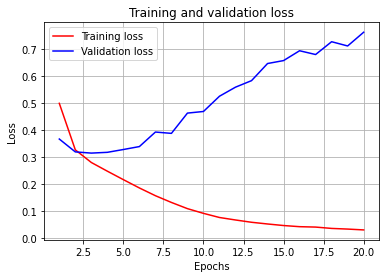

In [23]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()